In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
from scipy.spatial.distance import dice
# Map voxels to 2D feature space (work in 3D) Each voxel in 3D -> apply model

In [2]:
data_path = "./P2_data/3"
T1 = os.path.join(data_path, 'T1.nii')
T2_flair = os.path.join(data_path, 'T2_FLAIR.nii')
Labels = os.path.join(data_path, 'LabelsForTesting.nii')
result = os.path.join(data_path, 'T1_im3_seg_knn_init.nii')

T1_img = nib.load(T1)
T2_flair_img = nib.load(T2_flair)
Labels_img = nib.load(Labels)
result_img = nib.load(result)

print(T1_img.shape,
T2_flair_img.shape,
Labels_img.shape)

(240, 240, 48) (240, 240, 48) (240, 240, 48)


In [12]:
hdr = T1_img.header
#print(hdr)

In [3]:
def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()
    
    
def seg_data_to_nii(original_im, y_pred, features_nonzero_row_indicies):
    """
        Inputs: original_im (nibabel): original image nii file
                y_pred (np array): labels for all non-zero points
                features_nonzero_row_indicies (np array): indicies of non-zero points,
                                                          same length as y_pred
        Returns: segment_nii (nibabel): segmented labels nii file        
        """
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred) + 1
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)
    return segment_nii

def seg_correct_labels_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],0]
    class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],0]
    class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],0]
    mean0 = np.mean(class0, axis = 0)
    mean1 = np.mean(class1, axis = 0)
    mean2 = np.mean(class2, axis = 0)

    WM_label = np.argmax([mean0,mean1,mean2])
    CSF_label = np.argmin([mean0,mean1,mean2])
    if (WM_label + CSF_label) == 1:
        GM_label = 2
    elif (WM_label + CSF_label) == 3:
        GM_label = 0
    elif (WM_label + CSF_label) == 2:
        GM_label = 3

    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to 1
    y_pred_corrected_labels[y_pred == CSF_label] = 1
    #Assign GM to 2
    y_pred_corrected_labels[y_pred == GM_label] = 2
    #Assign WM to 1
    y_pred_corrected_labels[y_pred == WM_label] = 3

    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred_corrected_labels)
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

def apply_mask(target_img, gt_img):
    """
    Create mask using groundtruth image and apply it.
    
    Inputs: 
        gt_img: groundtuth mask
        target_img: raw data, apply mask to it
    
    Returns: 
        masked_img: target image with mask applied (background removed)
    """
    
    gt_data = gt_img.get_data().copy()
    target_data = target_img.get_data().copy()
    
    # Create mask: Select pixels higher than 0 in gt and set to 1
    gt_data[gt_data > 0] = 1
    
    # Apply mask
    target_data = np.multiply(target_data, gt_data)
    
    masked_img = nib.Nifti1Image(target_data, target_img.affine, target_img.header)
    
    return masked_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score


def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions  1) CSF (darkest) 2) GM (middle) 3) WM (light)
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == 1) * 1
    gt_CSF = (groundtruth_data == 1) * 1
    seg_GM = (segmented_data == 2) * 1
    gt_GM = (groundtruth_data == 2) * 1
    seg_WM = (segmented_data == 3) * 1
    gt_WM = (groundtruth_data == 3) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

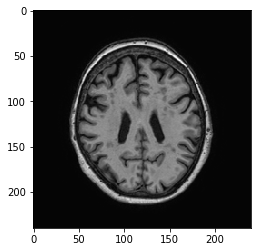

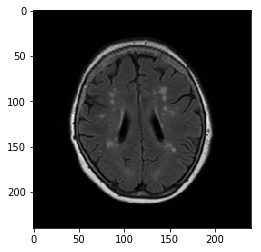

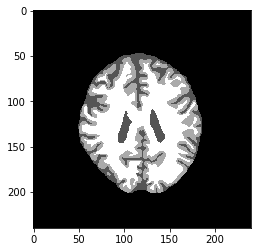

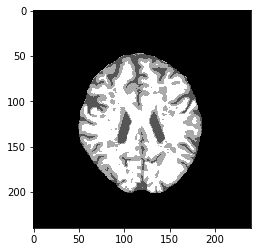

In [4]:
show_slice(T1_img, np.s_[:, :, 30])
show_slice(T2_flair_img, np.s_[:, :, 30])
show_slice(Labels_img, np.s_[:, :, 30])
show_slice(result_img, np.s_[:, :, 30])

# Data Preparation

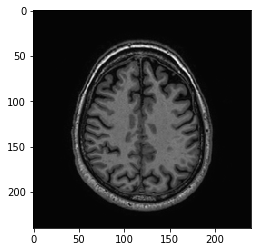

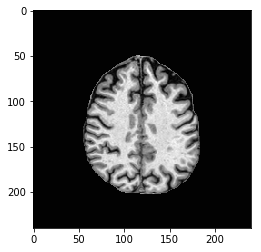

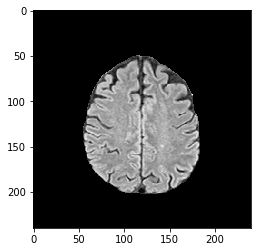

In [102]:
show_slice(T1_img, np.s_[:, :, 30])
T1_masked = apply_mask(T1_img, Labels_img)
T2_masked = apply_mask(T2_flair_img, Labels_img)
show_slice(T1_masked, np.s_[:, :, 30])
show_slice(T2_masked, np.s_[:, :, 30])

T1_flat = T1_masked.get_data().copy().flatten()
T2_flat = T2_masked.get_data().copy().flatten()

features = np.vstack((T1_flat, T2_flat))

features = np.transpose(features)

features_nonzero_row_indicies = [i for i, x in enumerate(features) if x.any()]
features_nonzero = features[features_nonzero_row_indicies]

# EM Algorithm

In [17]:
def gaussian_mixture(features, mean, cov):
    """
    Return Gaussian mixture function for a class.
    
    Inputs:
        features (numpy.ndarray): n by d dimentional array of features of points from feature space, where d is 
                                  is the dimentionality of feature space, n - number of points in the data.
        mean (numpy.ndarray): d-dimentional mean value.
        con (numpy.ndarray): d by d dimentional covariance matrix.
    
    Returns:
        (numpy.ndarray): Gaussian mixture for every point in feature space.
    """
    return np.exp(-0.5*(features - mean) @ inv(cov) @ np.transpose(features - mean)) / (2 * pi * sqrt(det(cov)))

def membership_weight(p0, p1, p2, a0, a1, a2):
    """
    Return membership weights for three classes.
    
    Inputs:
        p0 (numpy.ndarray): mixture component for the 0th class, which is a probability distribution.
        p1 (numpy.ndarray): mixture component for the 1st class, which is a probability distribution.
        p2 (numpy.ndarray): mixture component for the 2nd class, which is a probability distribution.
        a0 (float): the probability of the 0th class.
        a1 (float): the probability for the 1st class.
        a2 (float): the probability for the 2nd class.
        
    Returns:
        (numpy.ndarray): membership weights for each point from the feature space, 
    """
    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    
    return np.stack((w0, w1, w2), axis=1)

In [77]:
MAX_STEPS = 30
min_change = 0.01
# select initial classes for each point, it can be either 'kmeans' or 'random'
class_init = 'kmeans' 

## Initial Predictions

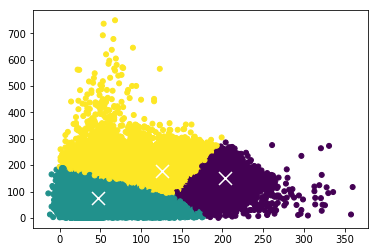

In [103]:
if class_init == 'kmeans':
    kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++').fit(features_nonzero)
    y_pred = kmeans.predict(features_nonzero)
    centroids = kmeans.cluster_centers_
    
    class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],:]
    class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],:]
    class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],:]

    # Compute mean and variance of each class
    mean0 = np.mean(class0, axis = 0)
    mean1 = np.mean(class1, axis = 0)
    mean2 = np.mean(class2, axis = 0)
    cov0 = np.cov(class0, rowvar = False)
    cov1 = np.cov(class1, rowvar = False)
    cov2 = np.cov(class2, rowvar = False)

    # Class distribution
    a0 = class0.shape[0] / features_nonzero.shape[0]
    a1 = class1.shape[0] / features_nonzero.shape[0]
    a2 = class2.shape[0] / features_nonzero.shape[0]
    
    plt.figure()
    plt.scatter(features_nonzero[:, 0], features_nonzero[:, 1], c=y_pred, s=25)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.show()
    
elif class_init == 'random':
    a0 = 1 / 3
    a1 = a0
    a2 = a0
    # select three random points as means
    indicies = np.random.randint(len(features_nonzero), size=3)
    centroids = features_nonzero[indicies]
    mean0 = centroids[0, :]
    mean1 = centroids[1, :]
    mean2 = centroids[2, :]
    cov0 = np.cov(features_nonzero, rowvar = False)
    cov1 = cov0
    cov2 = cov0
    
    plt.figure()
    plt.scatter(features_nonzero[:, 0], features_nonzero[:, 1], s=25)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='w', zorder=10)
    plt.show()
else:
    raise ValueError("Incorrect class_init value, shoulb be one from ('kmeans', 'random')")

********************************************************************
Step 0
Distribution change 0.019367
0.35045765033132864 0.24798608334680197 0.4015562663218694


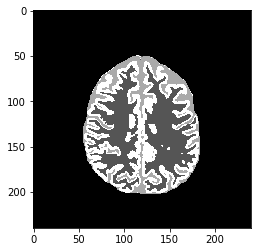

********************************************************************
Step 1
Distribution change 0.012648
0.3414024685897054 0.25681371589952107 0.4017838155107735


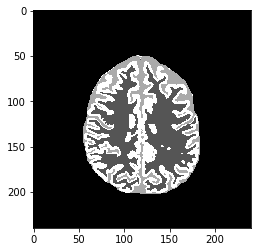

********************************************************************
Step 2
Distribution change 0.011236
0.33510764990600306 0.2657412999651233 0.39915105012887364


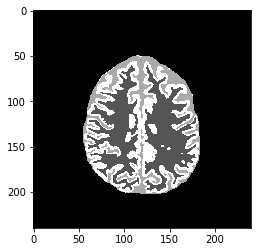

********************************************************************
Step 3
Distribution change 0.010024
0.33047585426644094 0.27390117134666586 0.39562297438689314


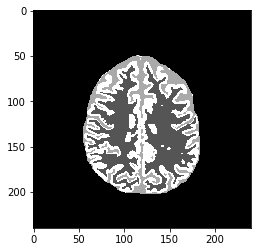

********************************************************************
Step 4
Distribution change 0.008464
0.32682656073224053 0.280808458875269 0.39236498039249046


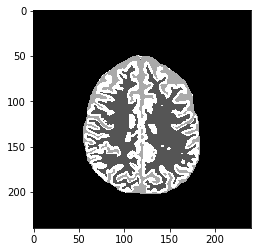

Loop stopped
CPU times: user 4min 50s, sys: 1.72 s, total: 4min 52s
Wall time: 4min 54s


In [104]:
%%time

cls_dist = np.array((a0, a1, a2))
n_steps = 0

while True:
    # Expectation step: Recompute labels for all the dataset given the current cluster parameters.
    # Compute Gaussian mixture model for each point
    p0 = np.apply_along_axis(partial(gaussian_mixture, mean = mean0, cov = cov0), 1, features_nonzero)
    p1 = np.apply_along_axis(partial(gaussian_mixture, mean = mean1, cov = cov1), 1, features_nonzero)
    p2 = np.apply_along_axis(partial(gaussian_mixture, mean = mean2, cov = cov2), 1, features_nonzero)

    # # Compute membership weight for each point
    weights = membership_weight(p0, p1, p2, a0, a1, a2)

    #################################### 

    # Maximization step: Use that classification to reestimate the parameters
    y_pred = np.argmax(weights, axis=1)

    # Class distribution
    _, counts = np.unique(y_pred, return_counts=True)
    a0 = counts[0] / features_nonzero.shape[0]
    a1 = counts[1] / features_nonzero.shape[0]
    a2 = counts[2] / features_nonzero.shape[0]
    
    cls_dist_new = np.array((a0, a1, a2))

    # Calculate mean and covariance for new classes
    mean0 = (1/counts[0]) * (weights[:, 0] @ features_nonzero)
    mean1 = (1/counts[1]) * weights[:, 1] @ features_nonzero
    mean2 = (1/counts[2]) * weights[:, 2] @ features_nonzero
    cov0 = (1/counts[0]) * (weights[:, 0] * np.transpose(features_nonzero - mean0)) @ (features_nonzero - mean0)
    cov1 = (1/counts[1]) * (weights[:, 1] * np.transpose(features_nonzero - mean1)) @ (features_nonzero - mean1)
    cov2 = (1/counts[2]) * (weights[:, 2] * np.transpose(features_nonzero - mean2)) @ (features_nonzero - mean2)
    
    segment_img = seg_data_to_nii(T1_img, y_pred, features_nonzero_row_indicies)
    dist_change = norm(cls_dist_new - cls_dist)
    print("********************************************************************")
    print("Step %d" % n_steps)
    print("Distribution change %f" % dist_change)
    print(a0, a1, a2)
    show_slice(segment_img, np.s_[:, :, 30])
    
    n_steps += 1
    
    # check whether we reached desired precision or max number of steps
    if (n_steps >= MAX_STEPS) or (dist_change <= min_change):
        print("Loop stopped")
        break
    else:
        cls_dist = cls_dist_new

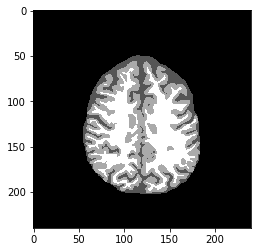

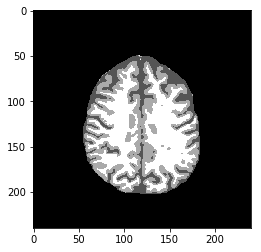

In [105]:
segment_img = seg_correct_labels_nii(T1_img, y_pred, features_nonzero, features_nonzero_row_indicies)
show_slice(Labels_img, np.s_[:, :, 30])
show_slice(segment_img, np.s_[:, :, 30])

## DICE Similarity Index

0.8851634855980166 0.8384293865218835 0.8733774323162493
CSF DICE = 0.8851634855980166 GM DICE = 0.8384293865218835 WM DICE = 0.8733774323162493


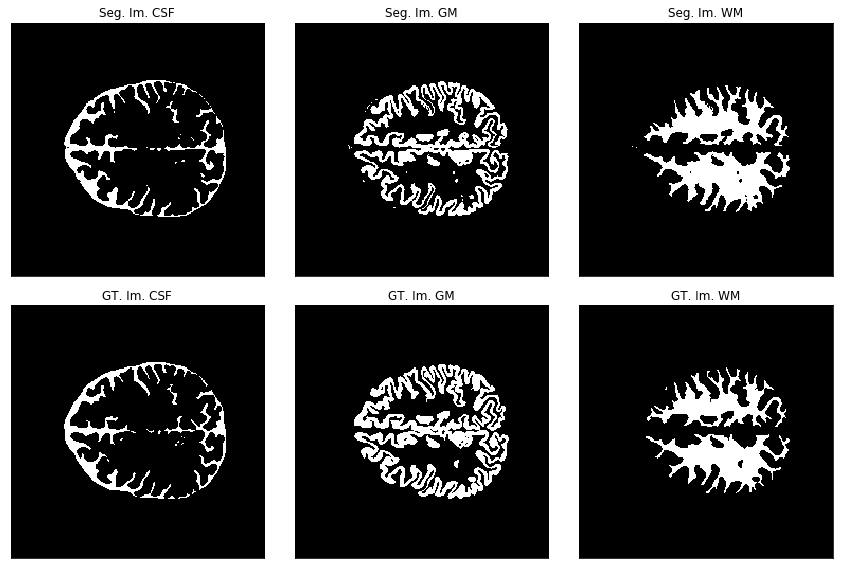

In [106]:
# Dice calculation
dice_CSF, dice_GM, dice_WM = dice_similarity(segment_img, Labels_img)
print(dice_CSF,dice_GM,dice_WM)
print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

# Visualizing the dice calculation for the three areas
segmented_data = segment_img.get_data().copy()
groundtruth_data = Labels_img.get_data().copy()

seg_CSF = (segmented_data == 1) * 1
gt_CSF = (groundtruth_data == 1) * 1
seg_GM = (segmented_data == 2) * 1
gt_GM = (groundtruth_data == 2) * 1
seg_WM = (segmented_data == 3) * 1
gt_WM = (groundtruth_data == 3) * 1


fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(12,8))
ax1.set_title("Seg. Im. CSF")
im1 = ax1.imshow(seg_CSF[:,:,30], cmap = "gray")
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.set_title("Seg. Im. GM")
im2 = ax2.imshow(seg_GM[:,:,30], cmap = "gray")
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.set_title("Seg. Im. WM")
im3 = ax3.imshow(seg_WM[:,:,30], cmap = "gray")
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax4.set_title("GT. Im. CSF")
im4 = ax4.imshow(gt_CSF[:,:,30], cmap = "gray")
ax4.axes.get_xaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)
ax5.set_title("GT. Im. GM")
im5 = ax5.imshow(gt_GM[:,:,30], cmap = "gray")
ax5.axes.get_xaxis().set_visible(False)
ax5.axes.get_yaxis().set_visible(False)
ax6.set_title("GT. Im. WM")
im6 = ax6.imshow(gt_WM[:,:,30], cmap = "gray")
ax6.axes.get_xaxis().set_visible(False)
ax6.axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

## Saving final result

In [107]:
nib.save(segment_img, os.path.join(data_path, 'T1_im5_seg_knn_init.nii'))